In [11]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [12]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles; 
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les 
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront 
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices 
# des sommets d'un element triangle, dans le sens antihoraire. 
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices 
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ; 
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2)); 
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ; 
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1  
                coordinates[p,0] = x[i,0]  
                coordinates[p,1] = x[j,0] 
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1 
                    p3 = p1 + n 
                    p4 = p2 + n 
                    e = e + 1 
                    elements3[e,0] = p1 
                    elements3[e,1] = p2 
                    elements3[e,2] = p3 
                    e = e + 1
                    elements3[e,0] = p4 
                    elements3[e,1] = p3 
                    elements3[e,2] = p2 
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j  
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j 
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j 

    return coordinates, elements3,dirichlet, neumann

In [13]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True)
    plt.show()
    plt.savefig('show.png')

In [14]:
def assemble(coordinates,elements3,dirichlet,neumann,ud,f):
    npoin = np.size(coordinates[:,0])
    ntriang = np.size(elements3[:,0])
    b = np.zeros(npoin)
    A = np.zeros((npoin,npoin)) # la matrice final de discretisation
    mat = np.zeros((3,3)) # MAT
    grad_i,grad_j= np.zeros((2,1)),np.zeros((2,1)) #les gradients qui seront utilisés
    for t in elements3:
        #calculer MAT
        p1,p2,p3 = coordinates[t[0]],coordinates[t[1]],coordinates[t[2]] #les points du triangle 
        alpha = (p2[0] - p1[0])*(p3[1] - p1[1]) - (p2[1] - p1[1])*(p3[0] - p1[0]) # alpha
        pg = (1/3)*(p1+p2+p3)
        fxg = (alpha/6)*f(pg[0],pg[1])       
        for i in range(3):
            b[t[i]] += (alpha/6)*fxg #first update of second membre
            grad_i = (1/alpha)*np.array([coordinates[t[(i+1)%3],1]-coordinates[t[(i+2)%3],1],coordinates[t[(i+2)%3],0]-coordinates[t[(i+1)%3],0]])
            for j in range(3):
                grad_j = (1/alpha)*np.array([coordinates[t[(j+1)%3],1]-coordinates[t[(j+2)%3],1],coordinates[t[(j+2)%3],0]-coordinates[t[(j+1)%3],0]])
                mat[i,j] = (alpha/2)*(grad_i.T)@grad_j
                #update la matrice A
                A[t[i],t[j]] += mat[i,j]
                A[t[j],t[i]] = A[t[i],t[j]]
    for t in elements3:        
        for p in dirichlet: #second update of second membre
            for i in range(3):      
                b[t[i]] -= ud(coordinates[p[0]][0],coordinates[p[0]][1])*A[t[i],p]
                        
    return A,b
'''def assemblage_seconde_membre(coordinates, elements3, dirichlet,neumann,ud,f):
    npoin = np.size(coordinates[:,0])
    ntriang = np.size(elements3[:,0])
    A = assemble(coordinates,elements3,dirichlet,neumann,npoin)
    b = np.zeros(npoin)
    for t in elements3:
        #trouver le barycentre
        p1,p2,p3 = coordinates[t[0]],coordinates[t[1]],coordinates[t[2]]
        pg = (1/3)*(p1+p2+p3)
        alpha = (p2[0]-p1[0])*(p3[1]-p1[1]) - (p3[0] - p1[0])*(p2[1]- p1[1])
        #calcule de alpha/6 * f(xg,yg)
        #abc = np.linalg.solve(np.array([[p1[0],p1[1],1.],[p2[0],p2[1],1.],[p3[0],p3[1],1.]]),np.array([f[t[0]],f[t[1]],f[t[2]]]))
        #fxg = abc[0]*pg[0] + abc[1]*pg[1] + abc[2]
        fxg = (alpha/6)*f(pg[0],pg[1])
        for i in range(3):
            b[t[i]] += (alpha/6)*fxg
        #####################################################
        for p in dirichlet:
            for i in range(3):     
                if (t[i] in dirichlet) : 
                    if ( (t[i] == 0 ) or (t[i] == npoin - 1) ):
                        b[t[i]] -= ud(coordinates[p[0]][0],coordinates[p[0]][1])*A[t[i],p]
                    elif ( (t[i] == int(np.sqrt(npoin)) -1 ) or (t[i] == npoin*npoin - npoin ) ):
                        b[t[i]] -= (1/2)*ud(coordinates[p[0]][0],coordinates[p[0]][1])*A[t[i],p]
                    else :
                        b[t[i]] -= (1/3)*ud(coordinates[p[0]][0],coordinates[p[0]][1])*A[t[i],p]
                else :
                        b[t[i]] -= (1/6)*ud(coordinates[p[0]][0],coordinates[p[0]][1])*A[t[i],p]
            
    return b'''


'def assemblage_seconde_membre(coordinates, elements3, dirichlet,neumann,ud,f):\n    npoin = np.size(coordinates[:,0])\n    ntriang = np.size(elements3[:,0])\n    A = assemble(coordinates,elements3,dirichlet,neumann,npoin)\n    b = np.zeros(npoin)\n    for t in elements3:\n        #trouver le barycentre\n        p1,p2,p3 = coordinates[t[0]],coordinates[t[1]],coordinates[t[2]]\n        pg = (1/3)*(p1+p2+p3)\n        alpha = (p2[0]-p1[0])*(p3[1]-p1[1]) - (p3[0] - p1[0])*(p2[1]- p1[1])\n        #calcule de alpha/6 * f(xg,yg)\n        #abc = np.linalg.solve(np.array([[p1[0],p1[1],1.],[p2[0],p2[1],1.],[p3[0],p3[1],1.]]),np.array([f[t[0]],f[t[1]],f[t[2]]]))\n        #fxg = abc[0]*pg[0] + abc[1]*pg[1] + abc[2]\n        fxg = (alpha/6)*f(pg[0],pg[1])\n        for i in range(3):\n            b[t[i]] += (alpha/6)*fxg\n        #####################################################\n        for p in dirichlet:\n            for i in range(3):     \n                if (t[i] in dirichlet) : \n        

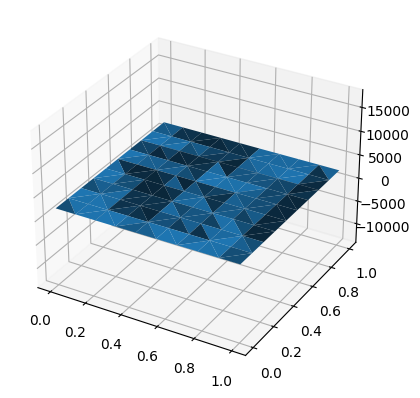

<Figure size 640x480 with 0 Axes>

In [15]:
n = 10
cordiantes,elements,dirichlet,neuman = maillage(n)
f = lambda x,y : 0
ud = lambda x,y : 1
A,b = assemble(cordiantes,elements,dirichlet,neuman,ud,f)
np.savetxt('mat.txt',A,fmt='%.2f',delimiter=',')
np.savetxt('b.txt',b,fmt='%.2f')
x = np.linalg.solve(A,b)
show(cordiantes,x)